In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [ ]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='A'

# WINDOW_SIZE = "10s"
# STRIDE= "5s"

WINDOW_SIZE = "60s"
STRIDE= "12s"

# WINDOW_SIZE = "30s"
# STRIDE= "6s"

# WINDOW_SIZE = "600s"
# STRIDE= "120s"

# WINDOW_SIZE = "3600s"
# STRIDE= "720s"

# api_key = DEEPSEEK_API_KEY  
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0


In [38]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

           start_time            end_time             activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11             sleeping
2 2011-11-28 10:25:44 2011-11-28 10:33:00            showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  preparing breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13        personal care
5 2011-11-28 10:51:41 2011-11-28 13:05:07    relaxing on couch
           start_time            end_time location      type     place  \
0 2011-11-28 02:27:59 2011-11-28 10:18:11      Bed  Pressure   Bedroom   
1 2011-11-28 10:21:24 2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom   
2 2011-11-28 10:21:44 2011-11-28 10:23:31    Basin       PIR  Bathroom   
3 2011-11-28 10:23:02 2011-11-28 10:23:36   Toilet     Flush  Bathroom   
4 2011-11-28 10:25:44 2011-11-28 10:32:06   Shower       PIR  Bathroom   

                      device  
0       Bedroom_Bed_Pressure  
1  Bathroom_Cabinet_Magnetic  
2         Bathroom_Basin_PIR  
3      Bathroom_Toilet_Flush  
4        Bathroom_Show

In [ ]:
from data_process.preprocess import convert_events_to_states

states_df = convert_events_to_states(dataset_b['devices'], DATASET)
print(states_df)
# state_df.head(40)

                                             state          start_time  \
0            st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   
1       st(Bathroom-CabinetDoorOpen, 10:21, 10:21) 2011-11-28 10:21:24   
2     st(Bathroom-NearBathroomBasin, 10:21, 10:23) 2011-11-28 10:21:44   
3           st(Bathroom-ToiletFlush, 10:23, 10:23) 2011-11-28 10:23:02   
4    st(Bathroom-NearBathroomShower, 10:25, 10:32) 2011-11-28 10:25:44   
..                                             ...                 ...   
404       st(Kitchen-FridgeDoorOpen, 15:13, 15:13) 2011-12-11 15:13:52   
405         st(Bathroom-ToiletFlush, 15:29, 15:30) 2011-12-11 15:29:03   
406   st(Bathroom-NearBathroomBasin, 15:41, 15:43) 2011-12-11 15:41:34   
407          st(Living-SeatOccupied, 15:43, 00:22) 2011-12-11 15:43:51   
408          st(Bedroom-BedOccupied, 00:31, 07:22) 2011-12-12 00:31:35   

               end_time location      type     place  \
0   2011-11-28 10:18:11      Bed  Pressure   Bedroom   

In [ ]:
def align_sensors_with_activities(sensor_df, activity_df):
    sensor_df['activity'] = None
    for i, sensor_row in sensor_df.iterrows():
        for j, activity_row in activity_df.iterrows():
            if (sensor_row['start_time'] <= activity_row['end_time'] and 
                sensor_row['end_time'] >= activity_row['start_time']):
                sensor_df.at[i, 'activity'] = activity_row['activity']
                break  
    return sensor_df

In [43]:
aligned_df=align_sensors_with_activities(states_df, dataset_b['activities'])
aligned_df=aligned_df.dropna()
print(aligned_df)

# empty_activity_rows = aligned_df[aligned_df['activity'].isnull()]
# print(empty_activity_rows)

                                             state          start_time  \
0            st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   
4    st(Bathroom-NearBathroomShower, 10:25, 10:32) 2011-11-28 10:25:44   
5         st(Kitchen-FridgeDoorOpen, 10:34, 10:34) 2011-11-28 10:34:23   
6       st(Kitchen-CupboardDoorOpen, 10:34, 10:37) 2011-11-28 10:34:44   
7              st(Kitchen-ToasterOn, 10:38, 10:42) 2011-11-28 10:38:00   
..                                             ...                 ...   
402     st(Kitchen-CupboardDoorOpen, 14:43, 14:44) 2011-12-11 14:43:05   
403     st(Kitchen-CupboardDoorOpen, 14:49, 14:50) 2011-12-11 14:49:47   
404       st(Kitchen-FridgeDoorOpen, 15:13, 15:13) 2011-12-11 15:13:52   
406   st(Bathroom-NearBathroomBasin, 15:41, 15:43) 2011-12-11 15:41:34   
407          st(Living-SeatOccupied, 15:43, 00:22) 2011-12-11 15:43:51   

               end_time  location      type     place  \
0   2011-11-28 10:18:11       Bed  Pressure   Bedroom 

In [ ]:

def segment_by_time_with_status_hci(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                                     stride: str = None, time_col: str = 'start_time', 
                                     end_time_col: str = 'end_time', activity_col: str = 'activity',
                                     drop_empty_intervals: bool = True) -> tuple:

    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a pandas.DataFrame")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y, if provided, must be a pandas.DataFrame")
    if time_col not in X.columns or end_time_col not in X.columns:
        raise ValueError(f"X must contain time column '{time_col}' and end time column '{end_time_col}'")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y must contain time column '{time_col}' and activity column '{activity_col}'")

    # Convert to Timedelta
    window_size = pd.Timedelta(window_size)
    if stride is None:
        stride = window_size
    else:
        if isinstance(stride, str) and '*' in stride:
            time_part, multiplier_part = stride.split('*')
            time_delta = pd.Timedelta(time_part)
            multiplier = float(multiplier_part)
            stride = time_delta * multiplier
        else:
            stride = pd.Timedelta(stride)

    # Ensure time columns are datetime type and sorted
    df = X.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df[end_time_col] = pd.to_datetime(df[end_time_col])
    df = df.sort_values(by=time_col)

    # Calculate time range
    st = df[time_col].iloc[0] - pd.Timedelta('1s')
    et = df[end_time_col].iloc[-1] + pd.Timedelta('1s')
    st_windows = pd.date_range(st, et - window_size, freq=stride)
    
    # Precompute window boundaries
    window_starts = pd.Series(st_windows)
    window_ends = window_starts + window_size

    # Initialize result lists
    X_list = []
    y_list = []

    # Create time arrays for state flow
    state_starts = df[time_col]
    state_ends = df[end_time_col]

    # Vectorized search for overlapping states
    for i, (win_st, win_et) in enumerate(zip(window_starts, window_ends)):
        # Find states overlapping with the window
        overlap_mask = (state_starts < win_et) & (state_ends > win_st)
        overlapping_states = df[overlap_mask].copy()
        
        if not overlapping_states.empty or not drop_empty_intervals:
            # Calculate state segments within the window, using Pandas clip method
            overlapping_states[time_col] = overlapping_states[time_col].clip(lower=win_st)
            overlapping_states[end_time_col] = overlapping_states[end_time_col].clip(upper=win_et)
            
            # Add to result list
            X_list.append(overlapping_states)
            
            # Handle label data
            if y is not None:
                y_segment = y[(y[time_col] >= win_st) & (y[time_col] < win_et)].copy()
                y_list.append(y_segment)

    # Return results
    if y is not None:
        return X_list, y_list
    else:
        return X_list, None

# Example usage
windows, labels = segment_by_time_with_status_hci(
    X=aligned_df,
    window_size=WINDOW_SIZE,
    # stride=STRIDE,
    time_col='start_time',
    end_time_col='end_time'
)

for i, window in enumerate(windows[:5]):
    print(f"Window {i}:")
    print(window)
    print()

窗口 0:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   

             end_time location      type    place                device  \
0 2011-11-28 02:28:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  

窗口 1:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:28:28   

             end_time location      type    place                device  \
0 2011-11-28 02:28:58      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  

窗口 2:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:28:58   

             end_time location      type    place                device  \
0 2011-11-28 02:29:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  

窗口 3:
                                   state         

In [45]:
len(windows)


34590

In [ ]:

def remove_duplicate_windows(dataframes):
    if not dataframes:
        return []

    result = [dataframes[0]] 
    count = 1 

    for i in range(1, len(dataframes)):
        prev_window = result[-1]
        current_window = dataframes[i]

        if (
            prev_window['device'].iloc[0] == current_window['device'].iloc[0]
            and prev_window['state'].iloc[0] == current_window['state'].iloc[0]
        ):
            count += 1
            if count <= 5:
                result.append(current_window)
        else:
            count = 1 
            result.append(current_window)

    return result

processed_dataframes = remove_duplicate_windows(windows)

if processed_dataframes:
    for i, df in enumerate(processed_dataframes):
        print(f"window {i + 1}:")
        print(df)
        print("-" * 20)

窗口 1:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   

             end_time location      type    place                device  \
0 2011-11-28 02:28:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  
--------------------
窗口 2:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:28:28   

             end_time location      type    place                device  \
0 2011-11-28 02:28:58      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  
--------------------
窗口 3:
                                   state          start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:28:58   

             end_time location      type    place                device  \
0 2011-11-28 02:29:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

   activity  
0  sleeping  
----------------

In [ ]:
import os
import pandas as pd

def save_dataframes_to_files(dataframes, folder_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/window_dataframes_{DATASET}_{WINDOW_SIZE}', 
                             truth_labels_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/truth_labels_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    Saves each DataFrame in a list to individual files, placing all files in a specified folder.
    Before removing the 'activity' column, it extracts all unique 'activity' information and saves it to a truth_labels.txt file, separated by commas.

    Parameters:
    dataframes (list): List of DataFrames.
    folder_path (str): Folder path to save the files.
    truth_labels_path (str): File path to save the ground truth labels.
    """

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    activity_labels = []  # List to store activity labels

    for i, df in enumerate(dataframes):
        if 'activity' in df.columns:
            # Extract all unique activity information
            unique_activities = ','.join(df['activity'].unique().tolist())
            activity_labels.append(unique_activities)

            # Remove 'activity' column
            df = df.drop(columns=['activity'])

        file_name = f'window_{i + 1}.csv'
        file_path = os.path.join(folder_path, file_name)
        df.to_csv(file_path, index=False)
        print(f'DataFrame {i + 1} saved to {file_path} (activity column removed)')

    # Write activity labels to file
    with open(truth_labels_path, 'w') as f:
        for item in activity_labels:
            f.write("%s\n" % item)
    print(f"Activity labels saved to {truth_labels_path}")

save_dataframes_to_files(processed_dataframes)

DataFrame 1 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_1.csv (已移除 activity 列)
DataFrame 2 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_2.csv (已移除 activity 列)
DataFrame 3 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_3.csv (已移除 activity 列)
DataFrame 4 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_4.csv (已移除 activity 列)
DataFrame 5 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_5.csv (已移除 activity 列)
DataFrame 6 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_6.csv (已移除 activity 列)
DataFrame 7 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_7.csv (已移除 activity 列)
DataFrame 8 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_8.csv (已移除 activity 列)
DataFrame 9 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_9.csv (已移除 activity 列)
DataFrame 10 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\window_10.csv (已移除 activity 列)
DataFrame 11 已保存到 LLM_gpt-4o-mini_A_30s/window_dataframes_A_30s\wind

In [ ]:
import os
import pandas as pd
from pathlib import Path
import re

def load_dataframes_from_files(folder_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/window_dataframes_{DATASET}_{WINDOW_SIZE}'):

    dataframes = []
    folder = Path(folder_path)

    if folder.exists():
        files = list(folder.glob('window_*.csv')) 

        def get_window_number(file_path):
            match = re.search(r'window_(\d+)\.csv', str(file_path))
            return int(match.group(1)) if match else 0

        sorted_files = sorted(files, key=get_window_number)

        for file_path in sorted_files:
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"警告：加载文件 {file_path} 时出错：{e}")
    else:
        print(f"警告：文件夹 {folder_path} 不存在。")

    return dataframes

loaded_dataframes = load_dataframes_from_files()

if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5: 
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break 

DataFrame 1:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:27:59   

              end_time location      type    place                device  
0  2011-11-28 02:28:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure  
--------------------
DataFrame 2:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:28:28   

              end_time location      type    place                device  
0  2011-11-28 02:28:58      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure  
--------------------
DataFrame 3:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:28:58   

              end_time location      type    place                device  
0  2011-11-28 02:29:28      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure  
--------------------
DataFrame 4:
                                          


    The data comes from a 30s-second time window around 2:27 AM.
    Here is the list of recorded events:
    [{'state': 'Bedroom-BedOccupied', 'place': 'bedroom', 'duration': 29}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 2:27 AM, ".
    - Indicate the subject's location (place) and describe their activities.
    - Use connecting words (like "then" or "while") to make the description flow smoothly.
    
Window 1:
Description: Around 2:27 AM, the subject was in the bedroom, where they occupied the bed for nearly 30 seconds.
Classified Activity: sleeping
Description Time: 1.10s, Tokens: 174
Classification Time: 0.92s, Tokens: 233


    The data comes from a 30s-second time window around 2:28 AM.
    Here is the list of recorded events:
    [{'state': 'Bedroom-BedOccupied', 'place': 'bedroom', 'duration': 30}]
    
    Please generate a natural language description based on these events, following 

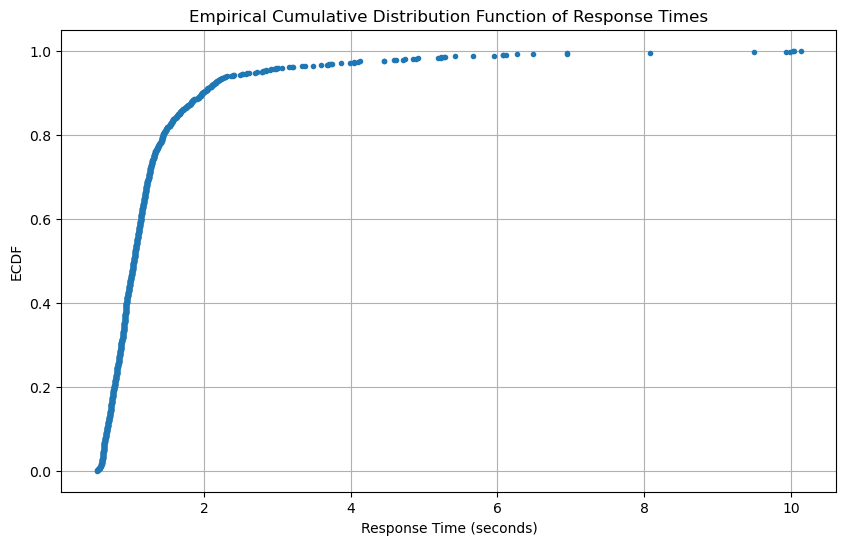

ECDF plot saved to: LLM_gpt-4o-mini_A_30s/response_time_ecdf.png


In [ ]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os

# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df, window_size=WINDOW_SIZE):
    """
    Convert sensor state data into a natural language description using DeepSeek LLM.
    Tracks token usage and response time.
    """
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    window_start = df['start_time'].min()
    # window_end = window_start + timedelta(seconds=window_size)
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    df = df.sort_values('start_time')
    
    events = []
    for _, row in df.iterrows():
        state_name = row['state'].split('(')[1].split(',')[0]
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            # 'location': row['location'].lower(),
            'place': row['place'].lower(),
            'duration': int(duration) if duration > 0 else 1
        }
        events.append(event)
    
    prompt = f"""
    The data comes from a {window_size}-second time window around {window_time_str}.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location (place) and describe their activities.
    - Use connecting words (like "then" or "while") to make the description flow smoothly.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are an helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):
    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room', and 'main entrance (main door)'
    The system captures the subject's interactions with: Shower, Basin, Cooktop, Maindoor, Fridge, Cabinet, Cupboard, Toilet, Microwave, Seat, Bed, Toaster.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    The possible activities are: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,snacking
    Your answer should be one or more of these activities using the following format: ACTIVITY=(activity name) or ACTIVITY=(activity name,activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/descriptions_{DATASET}_{WINDOW_SIZE}.txt', 
                 label_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/predictions_{DATASET}_{WINDOW_SIZE}.txt',
                 metrics_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/metrics_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") 

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [ ]:
from evaluation.evaluator import evaluate_predictions_split_activities

true_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/truth_labels_{DATASET}_{WINDOW_SIZE}.txt'
predicted_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/predictions_{DATASET}_{WINDOW_SIZE}.txt'
output_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/output_{DATASET}_{WINDOW_SIZE}.txt'


evaluate_predictions_split_activities(f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}', DATASET, true_labels_file, 
                                     predicted_labels_file,
                                      output_file)

C:\Users\leave\AppData\Local\Temp\ipykernel_24124\988371956.py:58: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵
d:\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


拆分活动后的评估结果已保存到 LLM_gpt-4o-mini_A_30s/output_A_30s.txt 和 LLM_gpt-4o-mini_A_30s/confusion_matrix_A_30s.png
